In [1]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import networkx as nx

from matplotlib import pyplot as plt
from sklearn import model_selection

import codecs
import json
import os

import node2vec

In [2]:
IMPORT = True
EXPORT = True
DISPLAY = True
VERBOSE = False
DATA_DIR = "new_data"
SEED = 221

In [40]:
def get_datasets(type='medium'):
    if type not in ['medium', 'all', 'mini']:
        raise Exception("Invalid type!")
        
    train_df = pd.read_csv(DATA_DIR + f'/train_{type}.csv').set_index("request_id")
    dev_df = pd.read_csv(DATA_DIR + f'/val_{type}.csv').set_index("request_id")
    return train_df, dev_df

In [41]:
train_df, dev_df = get_datasets('medium')

In [5]:
df = pd.concat([train_df, dev_df])
G = nx.Graph()
import ast

for i, row in df.iterrows():
    username = row.requester_username
    pizza = row.requester_received_pizza
    subreddits = row.requester_subreddits_at_request
    for subreddit in ast.literal_eval(str(subreddits)):
        G.add_edge(username, subreddit)

In [6]:
# ## Connectivity
# One more preprocessing step - get rid of extra disconnected components
nx.number_connected_components(G)
for component in nx.connected_components(G):
    print(len(component))
    if len(component) < 10:
        print(component)
print(len(G))
G = G.subgraph(next(nx.connected_components(G))).copy()
print(len(G))

5623
5623
5623


In [7]:
requesters = list(df.requester_username.unique())
subreddits = [n for n in G.nodes() if n not in requesters]

In [8]:
len(requesters), len(subreddits), len(G.nodes())

(353, 5270, 5623)

## node2vec

In [9]:
import networkx as nx
from node2vec import Node2Vec

# Create a graph
graph = G

# Precompute probabilities and generate walks - **ON WINDOWS ONLY WORKS WITH workers=1**
node2vec = Node2Vec(graph, dimensions=64, walk_length=30, num_walks=200, workers=4)  # Use temp_folder for big graphs

# Embed nodes
model = node2vec.fit(window=10, min_count=1, batch_words=4)  # Any keywords acceptable by gensim.Word2Vec can be passed, `diemnsions` and `workers` are automatically passed (from the Node2Vec constructor)

Computing transition probabilities: 100%|██████████| 5623/5623 [00:04<00:00, 1138.04it/s]


In [10]:
EMBEDDING_FILENAME = "pizza_embeddings.emb"
EMBEDDING_MODEL_FILENAME = 'pizza_embeddings.model'
EDGES_EMBEDDING_FILENAME = "pizza_embeddings_edges.emb"

In [11]:
# Look for most similar nodes
model.wv.most_similar(requesters[0])  # Output node names are always strings

[('phoenix', 0.7071039080619812),
 ('52weeksofcooking', 0.6793012022972107),
 ('ballparks', 0.6622568368911743),
 ('lookatmyboyfriend', 0.6494346857070923),
 ('WrestleWithThePlot', 0.6350957155227661),
 ('spicy', 0.6327152848243713),
 ('AlisonBrie', 0.629936933517456),
 ('camping', 0.6294975280761719),
 ('Padres', 0.6091541051864624),
 ('scaredshitless', 0.5739880204200745)]

In [12]:
# Save embeddings for later use
model.wv.save_word2vec_format(EMBEDDING_FILENAME)

# Save model for later use
model.save(EMBEDDING_MODEL_FILENAME)

# Use node2vec in a logistic regression

In [13]:
node_embeddings = model.wv
node_embeddings.word_vec('declutter', use_norm=True)

array([-0.20278798, -0.11589307,  0.10900376, -0.12438348,  0.04396758,
        0.01620117, -0.13023804, -0.10801091,  0.11833695, -0.01523131,
       -0.02414963,  0.012323  ,  0.20613037, -0.32121843,  0.11432598,
       -0.20505174,  0.05259169,  0.10707752, -0.02630493, -0.03761324,
       -0.11520293, -0.1014962 , -0.15354247, -0.06258017, -0.03832887,
       -0.0560052 ,  0.07817426,  0.13038675, -0.1414674 , -0.10263537,
       -0.06108527, -0.11529463, -0.18154415, -0.06367061,  0.17952646,
        0.05356575,  0.05953436,  0.12582228, -0.10097618,  0.07650121,
        0.08509489,  0.03445098,  0.17871882,  0.00702734,  0.02491984,
        0.09345736, -0.05333704,  0.01347772, -0.10924648, -0.04968961,
       -0.02281653,  0.08677085, -0.3882377 ,  0.08253405, -0.06444453,
        0.00639254,  0.02039573, -0.34832567,  0.01964482,  0.04212147,
        0.01243964,  0.09504791,  0.00421396,  0.22623464], dtype=float32)

In [14]:
all_nodes = np.array([node_embeddings.word_vec(node) for node in G.nodes()])

In [15]:
all_nodes.shape

(5623, 64)

In [16]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=100.0, early_exaggeration=12.0,
             learning_rate=200.0, n_iter=1000, n_iter_without_progress=300,
             min_grad_norm=1e-07, random_state=SEED)
embedding = tsne.fit_transform(all_nodes)


embedding = pd.DataFrame(embedding, index=G.nodes())
embedding.head()

,0,1
WangChi,22.546709,1.586141
camping,21.540302,2.098363
Awww,-11.320168,18.886805
Jokes,36.701477,-28.001137
PeopleBeingJerks,-23.394482,30.199133


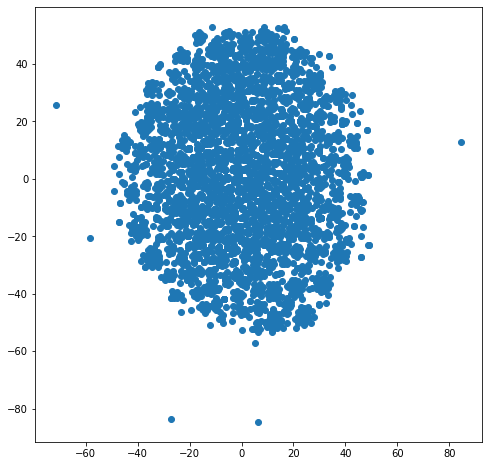

In [17]:
if (DISPLAY):
    # plot t-SNE
    plt.figure(figsize=(8, 8))
    plt.scatter(embedding.iloc[:,0], embedding.iloc[:, 1])
    plt.show()

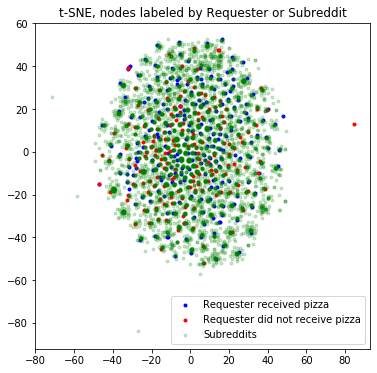

In [18]:
if (DISPLAY):
    plt.figure(figsize=(6, 6))
    plt.rcParams["scatter.marker"] = '.'
    group1 = df[df.requester_received_pizza == 1].requester_username.unique()
    group2 = df[df.requester_received_pizza == 0].requester_username.unique()
    
    group3 = subreddits
    plt.scatter(embedding.loc[group1].iloc[:,0],
                embedding.loc[group1].iloc[:,1], alpha=1.0, label="Requester received pizza", marker='.', color='b')
    plt.scatter(embedding.loc[group2].iloc[:,0],
                embedding.loc[group2].iloc[:,1], alpha=1.0, label="Requester did not receive pizza", marker='.', color='r')
    plt.scatter(embedding.loc[group3].iloc[:,0],
                embedding.loc[group3].iloc[:,1], alpha=0.2, label="Subreddits", marker='.', color='g')
    plt.legend()
    plt.title("t-SNE, nodes labeled by Requester or Subreddit")
    plt.show()

# Logistic regression

In [19]:
features = pd.DataFrame(all_nodes, index=G.nodes())

In [20]:
features

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
WangChi,1.275903,2.133255,-0.964705,3.410272,-6.171498,-6.946056,3.717872,-6.857498,-5.094883,2.025114,...,-2.109937,-0.126058,2.571389,-0.070959,0.134901,-0.672759,-4.710210,-4.756683,9.552661,3.647295
camping,0.994788,-0.227695,-0.776596,0.874374,-1.834737,-0.681901,-0.605000,-1.915385,-2.386846,-1.789703,...,-2.326961,-0.052910,0.450700,0.299467,-2.415856,-1.465128,0.225661,-3.030488,0.113895,0.831870
Awww,1.161094,-1.679093,-2.413600,-2.154944,-1.876510,-0.693099,-3.864234,-4.303877,-1.941921,0.158130,...,-1.127568,1.689111,1.781460,-2.618681,-1.268023,-0.404307,-1.028852,-7.558075,1.678588,3.626112
Jokes,-1.027158,0.120758,2.127502,0.435714,1.190390,1.553048,0.540719,-0.501172,1.339273,-7.504862,...,-5.397515,2.323064,-4.671278,-0.758020,0.210246,-0.441323,-1.470048,-8.318390,-7.599279,2.512078
PeopleBeingJerks,-4.924979,0.804310,-1.968465,0.901896,-1.319029,0.219025,-0.977893,-10.094284,-2.022822,0.189192,...,-3.094042,-0.595687,6.557288,-1.747845,-0.143949,-3.814823,-1.413676,-3.002005,7.427246,0.391932
popping,-2.982360,-3.404872,-5.107556,-4.160749,-2.273088,-3.066176,-3.078727,-1.729073,-7.371194,-1.299398,...,-2.169197,-1.486148,-3.301012,2.642574,-6.873387,0.431327,-4.232500,-7.157958,-1.637644,-5.297042
njpw,1.769115,2.421192,1.748438,-1.128811,-4.331126,-0.080306,-1.226006,-4.018813,-3.870376,-1.797296,...,-2.124964,-2.209496,-0.971352,-1.398876,-1.827276,-2.642726,-4.713394,-4.084080,0.163342,1.590890
ColoradoRockies,0.955595,-0.068750,-0.757025,0.817603,-5.363793,-1.530276,-3.989793,-4.767620,-3.048923,-0.711586,...,-4.150424,2.768979,-1.660464,-1.933837,-2.585275,-0.469398,-1.587272,-4.343697,0.653186,3.975190
FoodPorn,6.316478,3.352143,0.629179,-4.463685,-10.286300,-3.345861,-7.250066,-0.265968,-3.106470,-2.148660,...,-6.989082,-2.993024,-4.455683,5.594731,-5.296358,-3.791388,-3.671170,-4.420328,-0.234817,7.207711
baseball,7.997299,-0.916612,-1.428815,2.818097,-6.988531,2.239346,-1.879512,-6.247304,-6.256754,-6.692628,...,-1.590132,-7.169508,-1.020003,-2.008770,-2.298345,-6.616614,-4.365583,-2.709272,-1.207008,7.699918


In [37]:
train_dat = features.loc[train_df.requester_username]
train_dat['received_pizza'] = train_df.set_index('requester_username').requester_received_pizza
train_dat = train_dat.dropna(axis=0) #.dropna(how='all', axis=1)

dev_dat = features.loc[dev_df.requester_username]
dev_dat['received_pizza'] = dev_df.set_index('requester_username').requester_received_pizza
dev_dat = dev_dat.dropna(axis=0).dropna(how='all', axis=1)

X_train = train_dat[[col for col in train_dat.columns if col != 'received_pizza']]
y_train = train_dat['received_pizza']

X_dev = dev_dat[[col for col in dev_dat.columns if col != 'received_pizza']]
y_dev = dev_dat['received_pizza']

In [39]:
train_df.requester_username

request_id
7ekv2p                WangChi
ahf4ks                 Codadd
cq1lc3         Phoenix1Rising
aj2tm4              seasexual
a6zc8e           Maniac_Moxie
7htvke             brainpatte
9pqgrs             beasty_rey
a820ni        TheSplashFather
a8xrab               Kazoriyo
8e7kqb         SouthernDesire
8oewfi         Cyber_Marauder
8lymiz           WhitePlaguez
czd8jp             Internsh1p
9odg78              Datrinity
9o7w1n      TimothyBukinowski
7q0pe3             carolionel
694din           themightyi79
7nceiy                yaoikin
a2jbdk              anguineus
77vopi       TheRealKidsToday
cuwcml          PMMeMeiRule34
b5wnx8           ClintBartonn
6kqe6t    canIpleasehavepizza
amg1bj                 geo247
9rq1s2               jessfrss
5xezmi              middyccat
6hwwxh             KefkaNinja
8c9vo9          digitalbanksy
8ndkst            kassbirdman
8trp95             brand21new
                 ...         
7nbkuq          NAparentheses
cz07z5              madumbson

In [25]:
lr = sklearn.linear_model.LogisticRegression()

In [27]:
(X_train.columns == X_dev.columns).all()

True

In [28]:
lr.fit(X_train, y_train)
lr.score(X_dev, y_dev)

/home/clare/anaconda3/envs/cs221/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.5

In [29]:
y_pred = lr.predict(X_dev)

In [30]:
sklearn.metrics.roc_auc_score(y_dev, y_pred)

0.47874493927125505

In [31]:
sklearn.metrics.accuracy_score(y_dev, y_pred)

0.5

## Link prediction

In [26]:
lp = nx.algorithms.link_prediction.resource_allocation_index(G, ebunch=None)
lp = list(lp)
lp
#Compute the resource allocation index of all node pairs in ebunch.

[('translator', 'ChrisChanSonichu', 0),
 ('translator', 'DuelLinks', 0),
 ('translator', 'trashpandas', 0),
 ('translator', 'lostgeneration', 0),
 ('translator', '3dspiracy', 0),
 ('translator', 'fffffffuuuuuuuuuuuu', 0.012987012987012988),
 ('translator', 'spbeeking', 0),
 ('translator', 'destiny2', 0),
 ('translator', 'GarlicMarket', 0),
 ('translator', 'nintendo', 0),
 ('translator', 'RedDeadOnline', 0),
 ('translator', 'MiamiFilmmakers', 0.008771929824561403),
 ('translator', 'AsOldAsTheInternet', 0),
 ('translator', 'blurrypicturesofdogs', 0),
 ('translator', 'HydroHomies', 0),
 ('translator', 'Indiana', 0),
 ('translator', 'PuzzleAndDragons', 0),
 ('translator', 'ReverseChanceMe', 0),
 ('translator', 'FiftyFifty', 0),
 ('translator', 'IKEA', 0),
 ('translator', 'Botchedsurgeries', 0),
 ('translator', 'ProgrammerHumor', 0.012987012987012988),
 ('translator', 'Overwatch_Memes', 0),
 ('translator', 'stupidpol', 0),
 ('translator', 'dankmemes', 0),
 ('translator', 'Goruck', 0.0087719

In [ ]:
lp = nx.algorithms.link_prediction.jaccard_coefficient(G, ebunch=None)
#Compute the Jaccard coefficient of all node pairs in ebunch.

In [ ]:
lp = nx.algorithms.link_prediction.adamic_adar_index(G, ebunch=None)
#Compute the Adamic-Adar index of all node pairs in ebunch.

In [ ]:
lp = nx.algorithms.link_prediction.preferential_attachment(G[, ebunch])
#Compute the preferential attachment score of all node pairs in ebunch.

In [ ]:
lp = nx.algorithms.link_prediction.cn_soundarajan_hopcroft(G[, ebunch, community])
#Count the number of common neighbors of all node pairs in ebunch using community information.

In [ ]:
lp = nx.algorithms.link_prediction.ra_index_soundarajan_hopcroft(G[, ebunch, ...])
# Compute the resource allocation index of all node pairs in ebunch using community information.

In [ ]:
lp = nx.algorithms.link_prediction.within_inter_cluster(G[, ebunch, delta, ...]) 
# Compute the ratio of within- and inter-cluster common neighbors of all node pairs in ebunch.